# Gtzan audio classification using melspectograms

In [2]:
#Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import librosa

In [3]:
data_dir = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
classes=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Visualising how melspectograms are created using Librosa

(661794,)
22050
(1025, 1293)
(256, 1293)
(256, 1293)


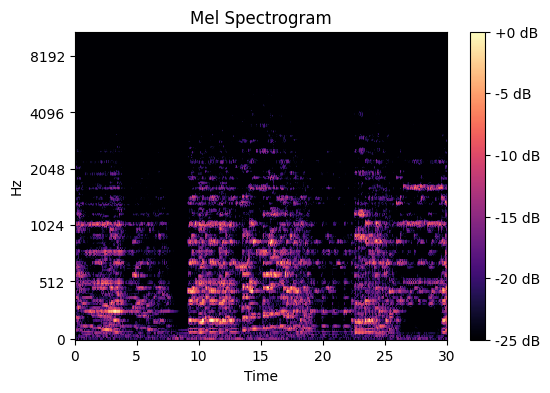

In [36]:
audio_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00007.wav'

y, sr = librosa.load(audio_file)
print(y.shape)   #number of frames
print(sr)    #samples per second
D = librosa.stft(y)
print(D.shape)
S = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=256, fmax=8000)

"""
n_mels = 256, you're dividing the spectrum (from 0 Hz to fmax) 
into 256 non-linear frequency bins.
more resolution at low frequencies and vica versa (like ears)
"""

print(S.shape)
S_db = librosa.power_to_db(np.abs(S), ref=np.max) #to db for visualisation
print(S_db.shape)
plt.figure(figsize=(6, 4))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr,vmin=-25,vmax=0)
#O db being the loudest sound and others being relative to that so we will take the values that are most relavant [ref=np.max],np.abs used to handle imaginary values

plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

Hiphop
(288, 432, 3)


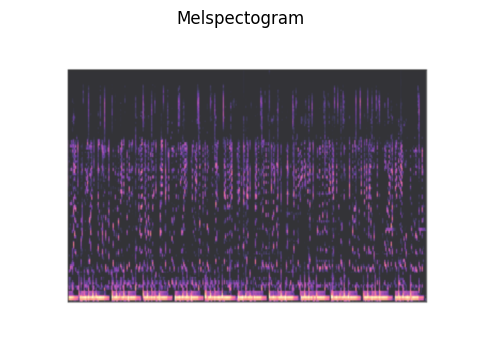

Metal
(288, 432, 3)


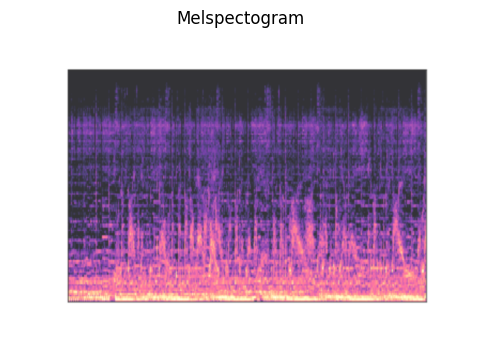

Classical
(288, 432, 3)


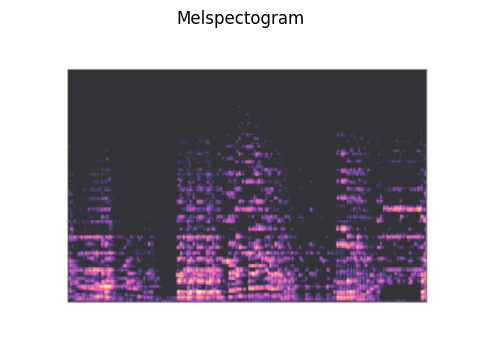

Rock
(288, 432, 3)


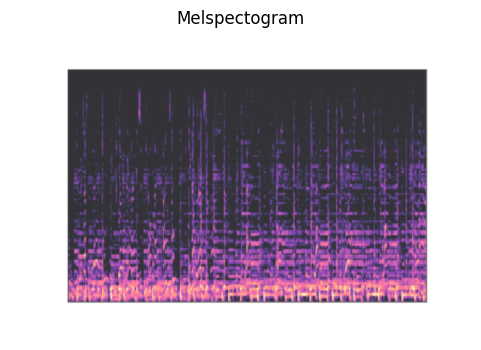

Blues
(288, 432, 3)


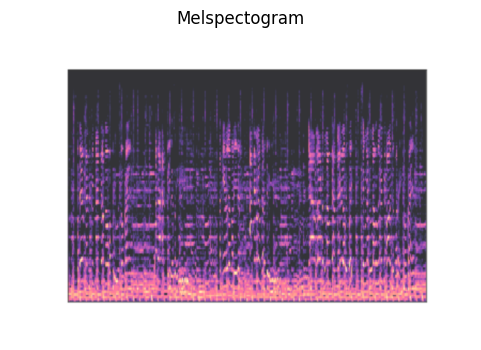

In [37]:
"""
Melspec spatial features can be visualised through cnn's each genre has different pattern 
of melspec which the model captures and thus can differentiate between music types
"""

total_genres=10

#file path for testing
dictionary={
    "Hiphop":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/hiphop/hiphop00001.png',
    "Metal":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/metal/metal00009.png',
    "Classical":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/classical/classical00007.png',
    "Rock":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/rock/rock00010.png',
    "Blues":'/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues/blues00048.png'
    
}

def printing_melspecs(file):
    raw=tf.io.read_file(file)
    image=tf.io.decode_png(raw,channels=3)
    
    print(image.shape)
    #print(image.dtype)
    #print(image)

    image=tf.image.convert_image_dtype(image,tf.float32)
    image=tf.image.adjust_brightness(image,delta=0.2)

    #This not needed as we converted image dtype to adjust brightness
    #image_arr=image.numpy().astype("float32") / 255.0  
    
    image_arr=image.numpy() #(to numpy for visualisation)
    
    plt.figure(figsize=(6,4))
    plt.imshow(image_arr,cmap='cool',interpolation='bicubic')

    plt.axis('off')
    plt.title('Melspectogram')
    plt.show()

for k,v in dictionary.items():
    print(k)
    printing_melspecs(v)

# Play Audio

In [43]:
from IPython.display import Audio
audio_file_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop/hiphop.00012.wav"

Audio(audio_file_path)

# Converting the audio files to chunks of melspectograms and grayscale for better feature extraction

In [4]:
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []
    
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)
        
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)

                    chunk_duration = 4
                    overlap_duration = 2
                    chunk_samples = chunk_duration * sample_rate
                    overlap_samples = overlap_duration * sample_rate
                    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        chunk = audio_data[start:end]
                        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)

                        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
  
                        data.append(mel_spectrogram)
                        labels.append(i_class)

                except Exception as e:
          
                    print(f"Error processing file {file_path}: {e}")

    data = np.array(data)
    labels = np.array(labels)

    data = data.astype('float32') / np.max(data)

    labels = to_categorical(labels, num_classes=len(classes))

    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    print(f"Data split: {X_train.shape}, {X_val.shape}, {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test

## Visualising chunks of grayscale melspectograms

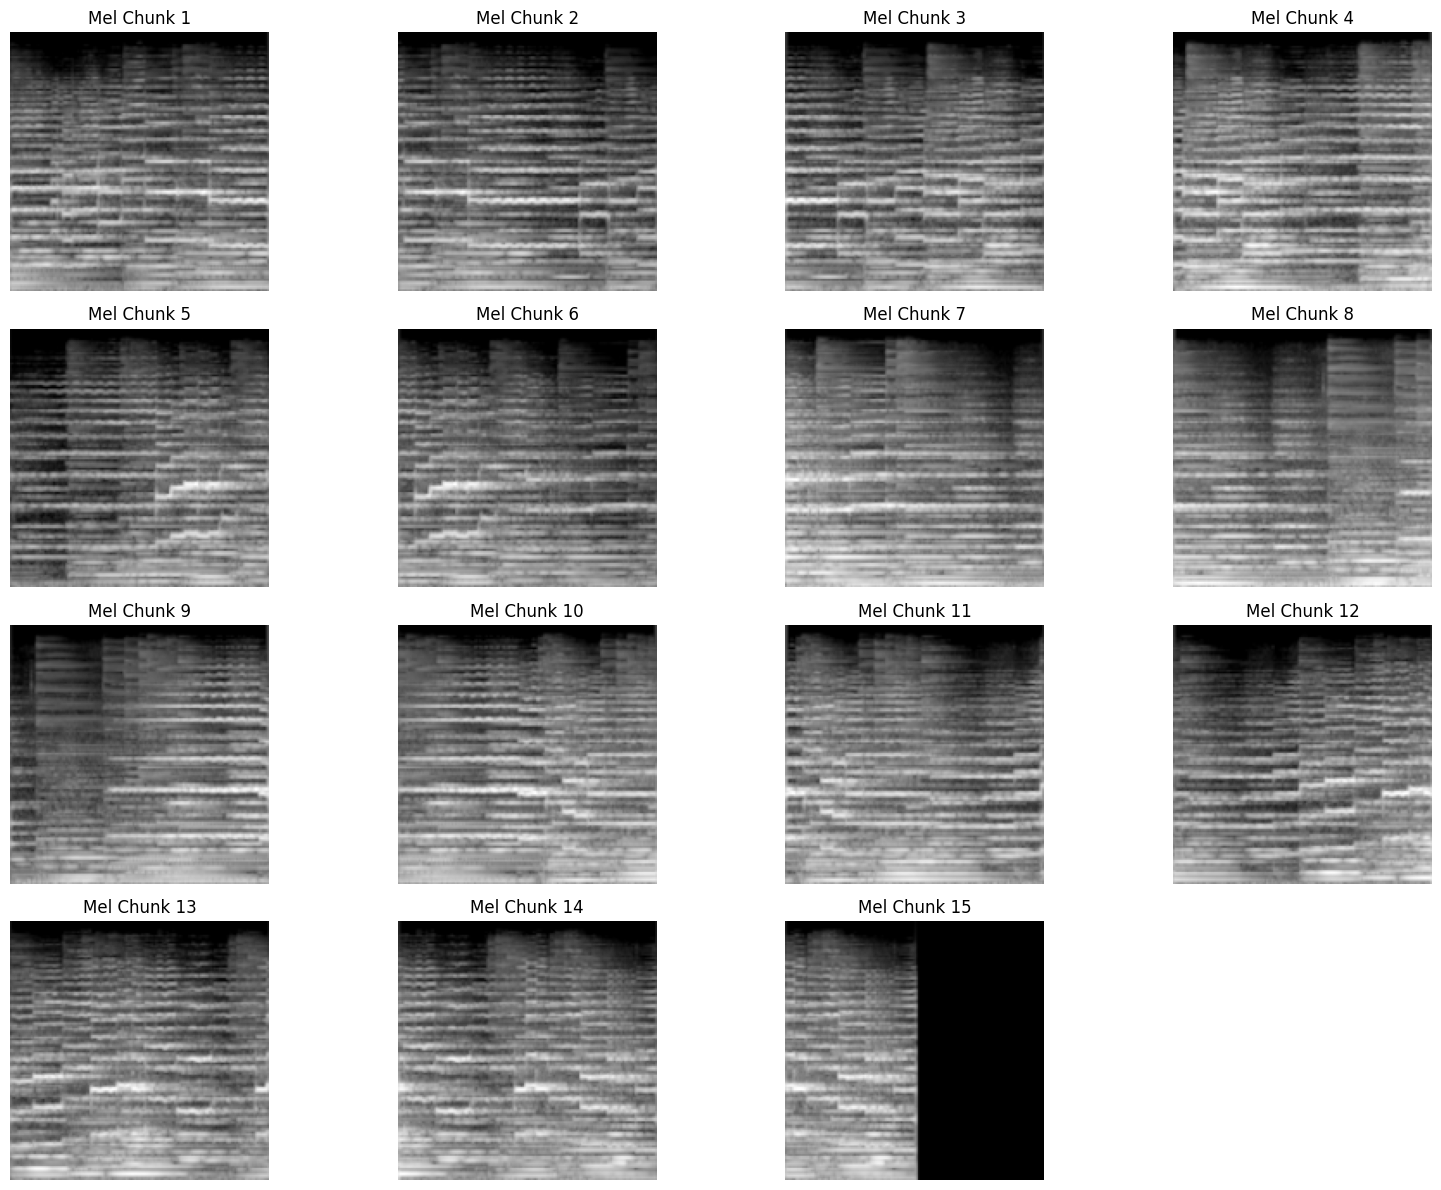

In [35]:
from skimage.transform import resize  
file_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00003.wav"
target_shape = (150, 150)
chunk_duration = 4 
overlap_duration = 2  

audio_data, sample_rate = librosa.load(file_path, sr=None)

chunk_samples = chunk_duration * sample_rate
overlap_samples = overlap_duration * sample_rate
num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

chunks = []

for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples
    chunk = audio_data[start:end]

    if len(chunk) < chunk_samples:
        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

    mel = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
    
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = (mel_db - np.min(mel_db)) / (np.max(mel_db) - np.min(mel_db))

    mel_resized = resize(np.expand_dims(mel_db, axis=-1), target_shape)
    chunks.append(np.squeeze(mel_resized))

chunks = np.array(chunks)

def plot_mel_chunks(mels, title_prefix="Chunk", n_cols=4):
    n = len(mels)
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=(4 * n_cols, 3 * n_rows))
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(mels[i], cmap='gray', origin='lower')
        plt.title(f"{title_prefix} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_mel_chunks(chunks, title_prefix="Mel Chunk")


## Splitting into Train Test and Validation sets

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data(data_dir, classes)

Processing-- blues


I0000 00:00:1744981704.104582      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz


/tmp/ipykernel_31/2766573015.py:18: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock
Data split: (10482, 150, 150, 1), (2246, 150, 150, 1), (2247, 150, 150, 1)


# Sequential Model built using Keras 

In [21]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

model = Sequential([
 
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
           input_shape=X_train[0].shape),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    
    Dropout(0.3), 
    
    Flatten(),
    Dense(units=1200, activation='relu'),
    Dropout(0.45), 
    
    Dense(units=len(classes), activation='softmax')
])

model.summary()

"""
Tried batchnormalization and kernel regularizer but it was causing low accuracy
"""

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
from tqdm.keras import TqdmCallback

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', 
                                  factor=0.5,  
                                  patience=3,  
                                  verbose=1, 
                                  min_lr=1e-6) 

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('/kaggle/working/model_weights.keras', 
                              save_best_only=True, 
                              monitor='val_loss', 
                              mode='min')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[checkpoint,TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.1563 - loss: 2.2033 - val_accuracy: 0.3629 - val_loss: 1.7734
Epoch 2/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.3280 - loss: 1.7854 - val_accuracy: 0.3825 - val_loss: 1.6259
Epoch 3/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.3708 - loss: 1.6604 - val_accuracy: 0.4261 - val_loss: 1.5546
Epoch 4/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4236 - loss: 1.5394 - val_accuracy: 0.4577 - val_loss: 1.4733
Epoch 5/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4697 - loss: 1.4373 - val_accuracy: 0.5263 - val_loss: 1.3068
Epoch 6/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5081 - loss: 1.3465 - val_accuracy: 0.5588 - val_loss: 1.2320
Epoch 7/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5522 - loss: 1.2475 - val_accuracy: 0.5922 - val_loss: 1.1726
Epoch 8/40
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5839 - loss: 1.1688 - 

# Plotting Loss and Accuracy

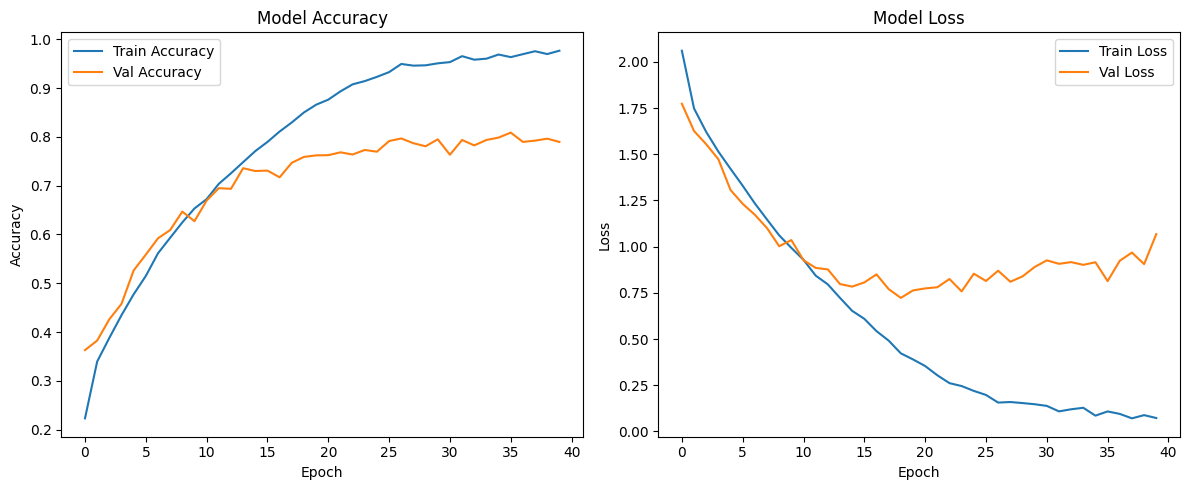

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7682 - loss: 1.2078
Test Accuracy: 77.30%


# Confusion Matrix

<Figure size 1200x1000 with 0 Axes>

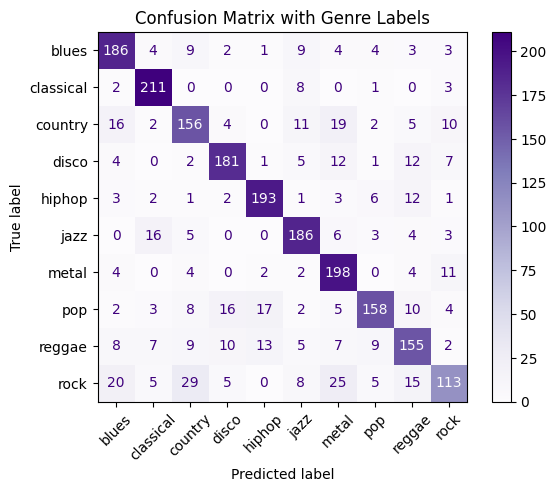

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_classes = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

genre_labels = [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)

plt.figure(figsize=(12, 10))
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix with Genre Labels")
plt.show()

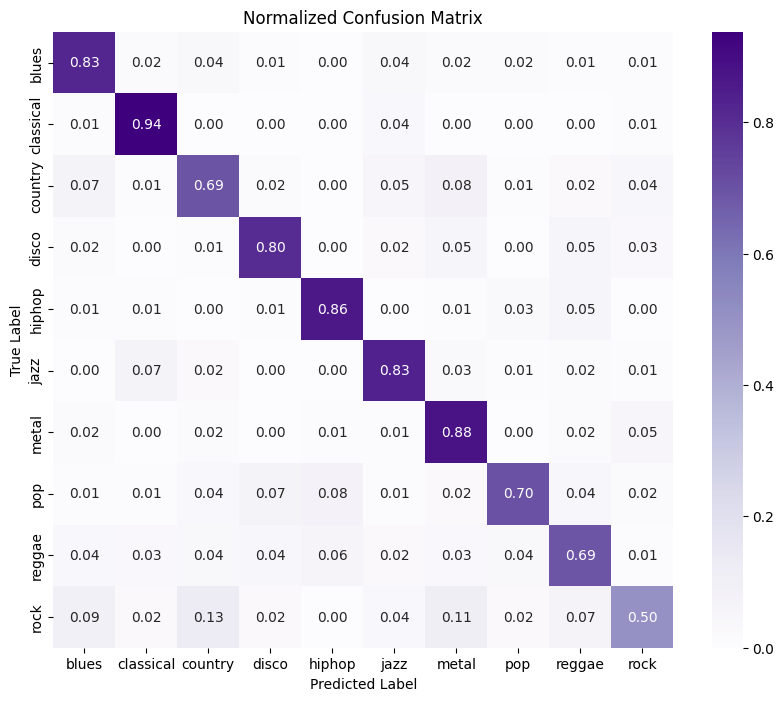

In [40]:
import seaborn as sns
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Purples', xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

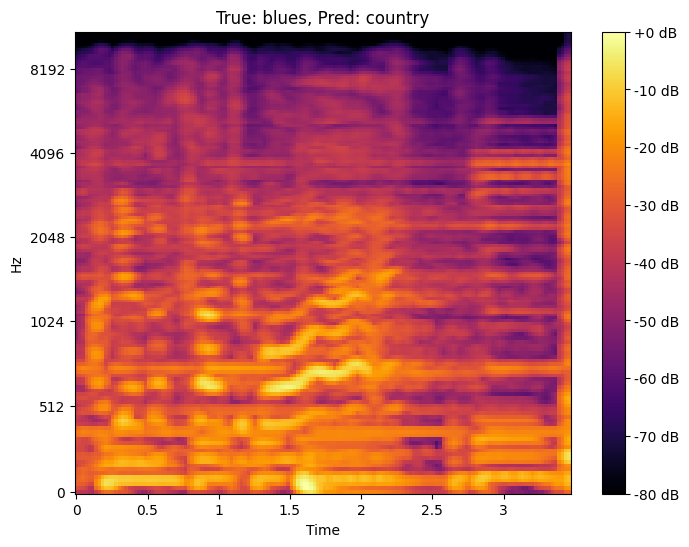

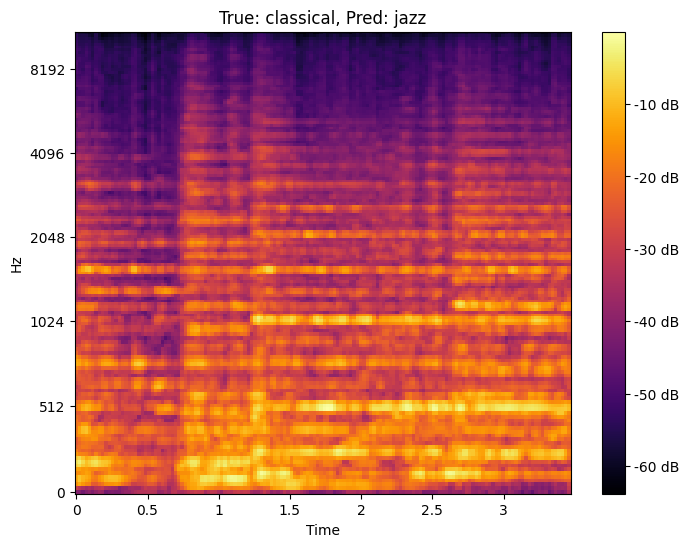

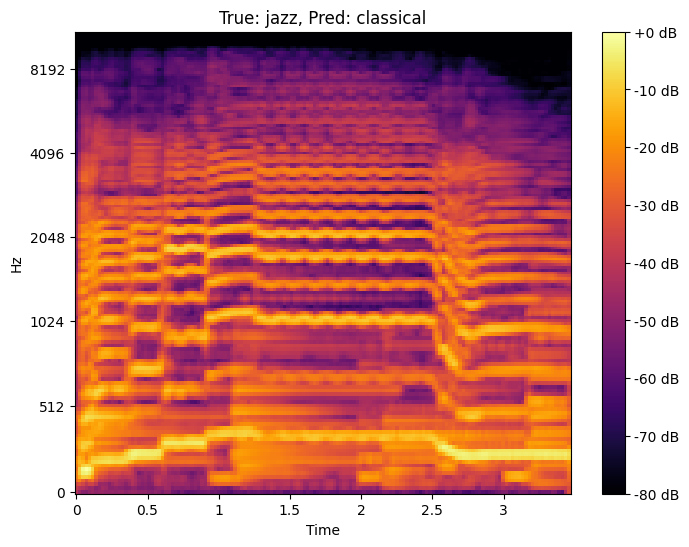

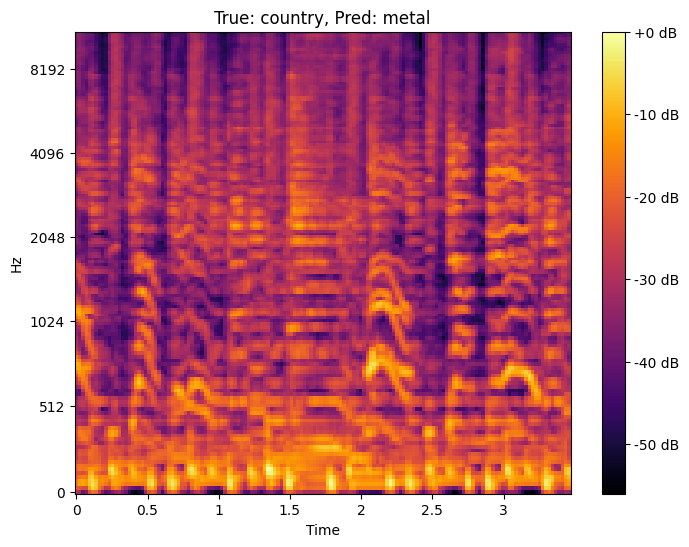

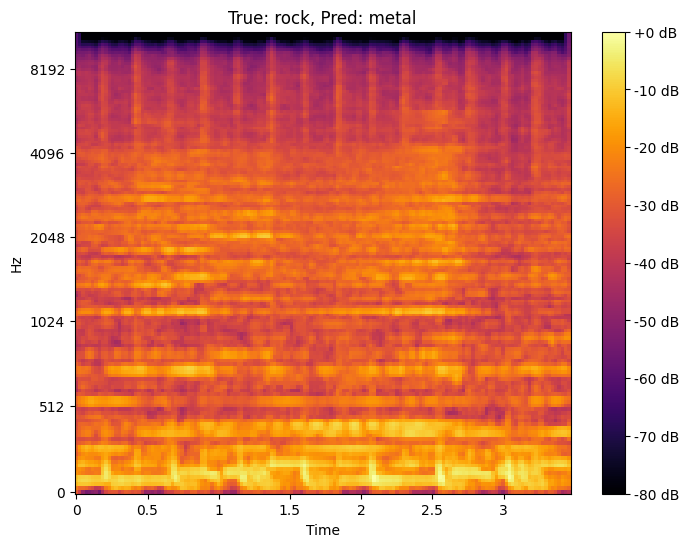

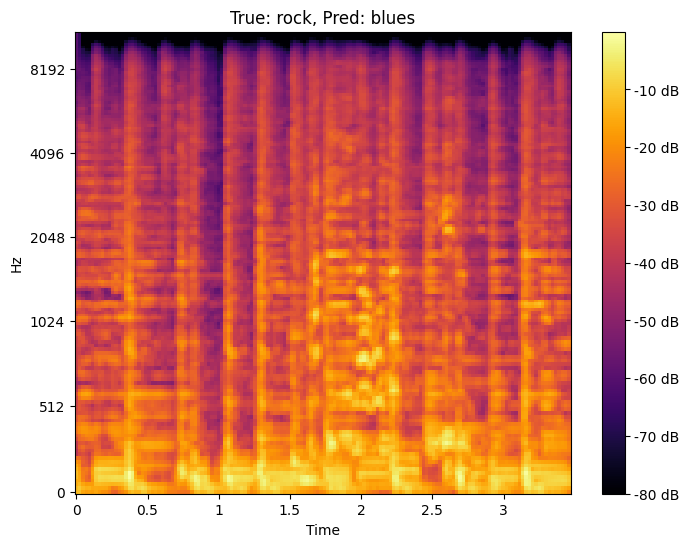

In [42]:
import librosa.display

misclassified_idx = np.where(predicted_classes != true_classes)[0]

for idx in misclassified_idx[:6]:  
    mel_spec = X_test[idx].squeeze() 

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(8, 6))
    librosa.display.specshow(mel_spec_db, cmap='inferno', x_axis='time', y_axis='mel')
    plt.title(f"True: {classes[true_classes[idx]]}, Pred: {classes[predicted_classes[idx]]}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [39]:
from sklearn.metrics import classification_report
true_classes = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=classes)

print(report)

              precision    recall  f1-score   support

       blues       0.76      0.83      0.79       225
   classical       0.84      0.94      0.89       225
     country       0.70      0.69      0.70       225
       disco       0.82      0.80      0.81       225
      hiphop       0.85      0.86      0.86       224
        jazz       0.78      0.83      0.81       223
       metal       0.71      0.88      0.79       225
         pop       0.84      0.70      0.76       225
      reggae       0.70      0.69      0.70       225
        rock       0.72      0.50      0.59       225

    accuracy                           0.77      2247
   macro avg       0.77      0.77      0.77      2247
weighted avg       0.77      0.77      0.77      2247



### Saving the model

In [30]:
model.save('my_model.h5')  